 # Extractor

https://github.com/mesnico/TERAN

https://github.com/sebastian-sz/efficientnet-v2-keras#quickstart

In [ ]:
# Install
!pip install git+https://github.com/sebastian-sz/efficientnet-v2-keras@main

In [ ]:


# Import package:
from efficientnet_v2 import EfficientNetV2L
import tensorflow as tf


# Or to extract features / fine tune:
backbone = EfficientNetV2L(
   weights='imagenet', 
   input_shape=(480, 480, 3),
   include_top=False
)


model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D()
])

model.summary()


In [1]:
import pandas as pd
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.preprocessing import image
import numpy as np
from PIL import ImageFile
import tensorflow as tf
import io
import PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
df= pd.read_csv("../input/flickr-image-dataset/flickr30k_images/results.csv", sep='|')

In [ ]:
df

In [3]:
import json as jsonmod


dataset = jsonmod.load(open("../input/karpathy-splits/dataset_flickr30k.json", 'r'))['images']

In [ ]:
dataset[0]

In [ ]:
len(dataset)

In [ ]:
dataset[1]["filename"]

In [ ]:
len(df["image_name"].unique())

In [4]:
from tqdm.notebook import tqdm
imagenes=[]
for item in tqdm(range(len(dataset))):
    imagenes.append(dataset[item]["filename"])

  0%|          | 0/31014 [00:00<?, ?it/s]

In [6]:
df_img= pd.DataFrame(columns= ["name_img"], data= imagenes)

In [9]:
df_img.iloc[130]

name_img    1042359076.jpg
Name: 130, dtype: object

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=df_img,
directory= "../input/flickr-image-dataset/flickr30k_images/flickr30k_images/",
x_col="name_img",
batch_size=256,
seed=42,
y_col=None,
class_mode=None,
shuffle=False,
target_size=(480, 480))

In [ ]:
len(train_generator.filenames)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16,10))
for img in train_generator:
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img[i])
    break
plt.show()

In [ ]:
train_generator.reset()
pred=model.predict_generator(train_generator, verbose=1)

In [ ]:
pred.shape

In [ ]:
np.save("EFFV2L_F30K.npy",pred)

In [ ]:
len(train_generator.filenames)

In [ ]:
np.save("filenames.npy",train_generator.filenames) 

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
len(dataset)

In [ ]:
dataset[0]["sentences"][1]

In [ ]:
textos=[]
indices=[]
for i in dataset:
    for j in i["sentences"]:
        textos.append(j["raw"])
        indices.append( (j["imgid"],j["sentid"]) )

In [ ]:
len(textos)

In [ ]:
len(dataset)

In [ ]:
a=  model.encode( textos[:80000])

In [ ]:
a2=  model.encode( textos[80000:])

In [ ]:
txt=np.concatenate([a,a2],axis=0)

In [ ]:
np.save("MPNET_F30K.npy",txt) 

# Hands on

Este hands on tiene las siguientes posibilidades

0. Sobre el entrenamiento y los datos
1. Búsqueda de imágenes en base a las descripciones originales
2. Búsqueda de imágenes en base a imágenes (utilizando rep pre entrenadas)
3. Búsqueda de imágenes en base a imágenes (utilizando proyección al espacio aprendido)
4. Búsqueda de imágenes en base a cualquier texto ingresado! 

## 0. Sobre el entrenamiento y los datos

In [1]:
import json as jsonmod
import numpy as np

dataset = jsonmod.load(open("../input/karpathy-splits/dataset_flickr30k.json", 'r'))['images']

In [2]:
dataset=dataset[:3000]
print(len(dataset))
print(len(dataset[0]))

train_indices,val_indices,test_indices=[],[],[]
data_text=[] #querys train
 #dictionary ground truth retrieval img o text
val_r_img, val_r_text, test_r_img, test_r_text= {},{},{},{} 
for i in range(len(dataset)):
  if dataset[i]["split"]=="train":
    train_indices.append(i)
    for t in dataset[i]["sentids"]:
      data_text.append(t)


  if dataset[i]["split"]=="val":
    val_indices.append(i)
    for t in dataset[i]["sentids"]:
      val_r_text[i]= dataset[i]["sentids"]
      val_r_img[t]= dataset[i]["imgid"]

  if dataset[i]["split"]=="test":
    test_indices.append(i)
    for t in dataset[i]["sentids"]:
      test_r_text[i]= dataset[i]["sentids"]
      test_r_img[t]= dataset[i]["imgid"]

print("Train-Val-Test")
print(len(train_indices),len(val_indices),len(test_indices))
print("Val-Test")
print("img: ", len(val_r_text.keys()), len(test_r_text.keys()))
print("text: ", len(val_r_img.keys()), len(test_r_img.keys()))
print("-"*20)
universe_text= data_text+ list(val_r_img.keys())+list(test_r_img.keys()) #captions
universe_img= train_indices+val_indices+test_indices
print(len(universe_img),len(universe_text))

3000
5
Train-Val-Test
2791 101 108
Val-Test
img:  101 108
text:  505 540
--------------------
3000 15000


In [3]:

a= np.load("/kaggle/input/handaon/512_0test_metrics.npy",allow_pickle=True)
r_img= a[0][0][0][0] # Recall img 1,5,10
ndcg_i2t=a[0][0][1] #ndcg i2t
ndcg_t2i=a[0][0][2] #ndcg t2i
tops=a[0][0][3] #query,rank
r_text=a[0][1][0][0] # Recall text 1,5,10

print("METRICAS DE TEST: ")
print("\n", "-"*20,"\n" )
print("RECALL: ")
print("TEXT RETRIEVAL: @1: ", np.round(r_text[0],1), "@5: ",np.round(r_text[1],1), "@10: ",np.round(r_text[2],1) )
print("IMAGE RETRIEVAL: @1: ", np.round(r_img[0],1), "@5: ",np.round(r_img[1],1), "@10: ",np.round(r_img[2],1) )
print("\n", "-"*20,"\n" )
print("nDCG@25: ")
print("TEXT RETRIEVAL: ROUGE-L: ", np.round(ndcg_i2t[0],3), "SPICE: ",  np.round(ndcg_i2t[1],3) )
print("IMAGE RETRIEVAL: ROUGE-L: ",  np.round(ndcg_t2i[0],3), "SPICE: ",  np.round(ndcg_t2i[1],3) )

METRICAS DE TEST: 

 -------------------- 

RECALL: 
TEXT RETRIEVAL: @1:  9.4 @5:  33.7 @10:  51.7
IMAGE RETRIEVAL: @1:  14.3 @5:  40.6 @10:  56.1

 -------------------- 

nDCG@25: 
TEXT RETRIEVAL: ROUGE-L:  0.274 SPICE:  0.086
IMAGE RETRIEVAL: ROUGE-L:  0.423 SPICE:  0.124


In [34]:
!pip install deep-translator

## 1. Búsqueda de imágenes en base a las descripciones originales

Insertar un indice del 0 al 540. Cada 5 son el distintos textos asociados a una sola imagen.

In [80]:
indice= 1

In [86]:

ejemplo=tops[indice]
texto= ejemplo[0]
imagenes=ejemplo[1]
imagenes_top=[]

for i in range(len(dataset)):
    if dataset[i]["split"]=="test":
        l=dataset[i]["sentids"]
        for t in l:
            if t==texto:
                caption_query= dataset[i]["sentences"][l.index(t)]["raw"]
                image_gt= (i,dataset[i]["filename"] )
    if i in imagenes:
        imagenes_top.append((i,dataset[i]["filename"] ))
        
print(caption_query)


from deep_translator import GoogleTranslator
translated = GoogleTranslator(source='en', target='es').translate(caption_query)

print(translated)

A man in an orange hat starring at something.
Un hombre con un sombrero naranja protagonizando algo.


Text(0.5, 1.0, 'Imagen asociada al texto de query')

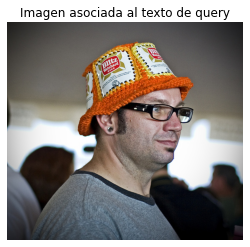

In [83]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + image_gt[1])
imgplot = plt.imshow(img)
plt.axis('off')
plt.title("Imagen asociada al texto de query")
plt.show()


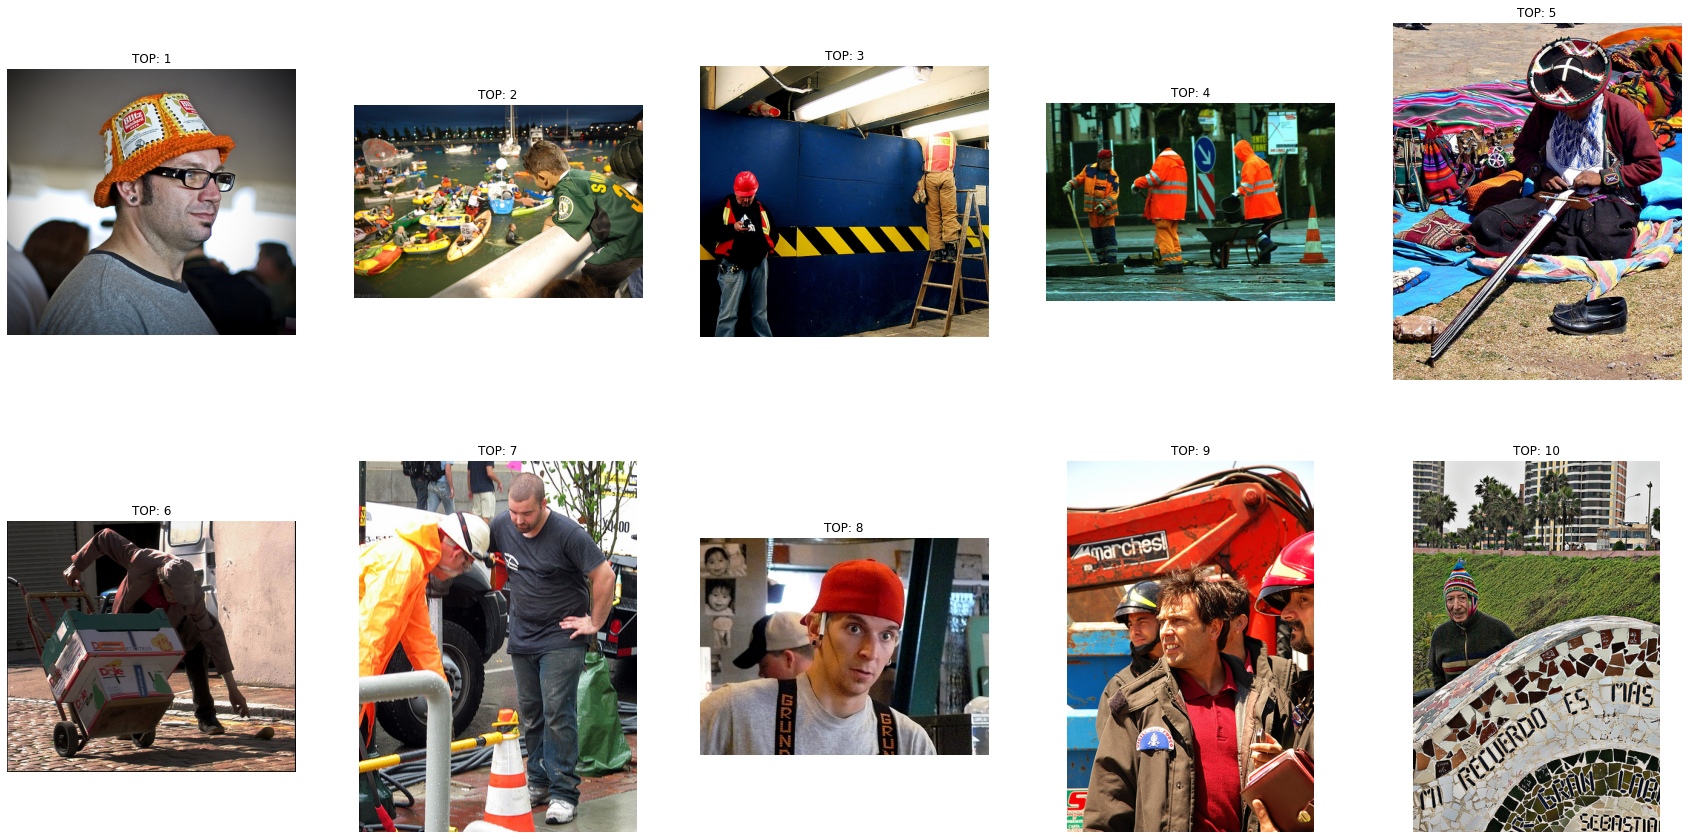

In [87]:
_, axs = plt.subplots(2, 5, figsize=(30, 15))
axs = axs.flatten()
imgs= [mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + imagenes_top[i][1]) for i in range(10)]
c=0
for img, ax in zip(imgs, axs):
    c+=1
    ax.imshow(img)
    ax.axis('off')
    ax.set_title( "TOP: "+str(c) )
    
plt.show()

## 2. Búsqueda de imágenes en base a imágenes (utilizando rep pre entrenadas)


In [4]:
import pickle
param = pickle.load(open("/kaggle/input/handaon/512_0_model.pkl", "rb"), encoding='latin1') #modelo pre entrenado
param[0] = np.reshape(param[0], [ 512,1280]) #E^V [k,1280]
param[1] = np.reshape(param[1], [ 512, 768 ]) #E^T [k,768]


visual_matrix= np.load("/kaggle/input/handaon/EFFV2L_F30K.npy")
visual_matrix=visual_matrix[universe_img,:]/np.max(visual_matrix)

Ingresar un indice de 0 a 3000

In [20]:
indice_input_= 0

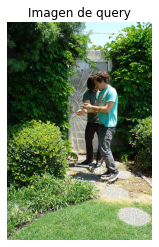

In [16]:
input_=visual_matrix[indice_input_,:]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + dataset[universe_img[indice_input_]]["filename"])
imgplot = plt.imshow(img)
plt.axis('off')
plt.title("Imagen de query")
plt.show()


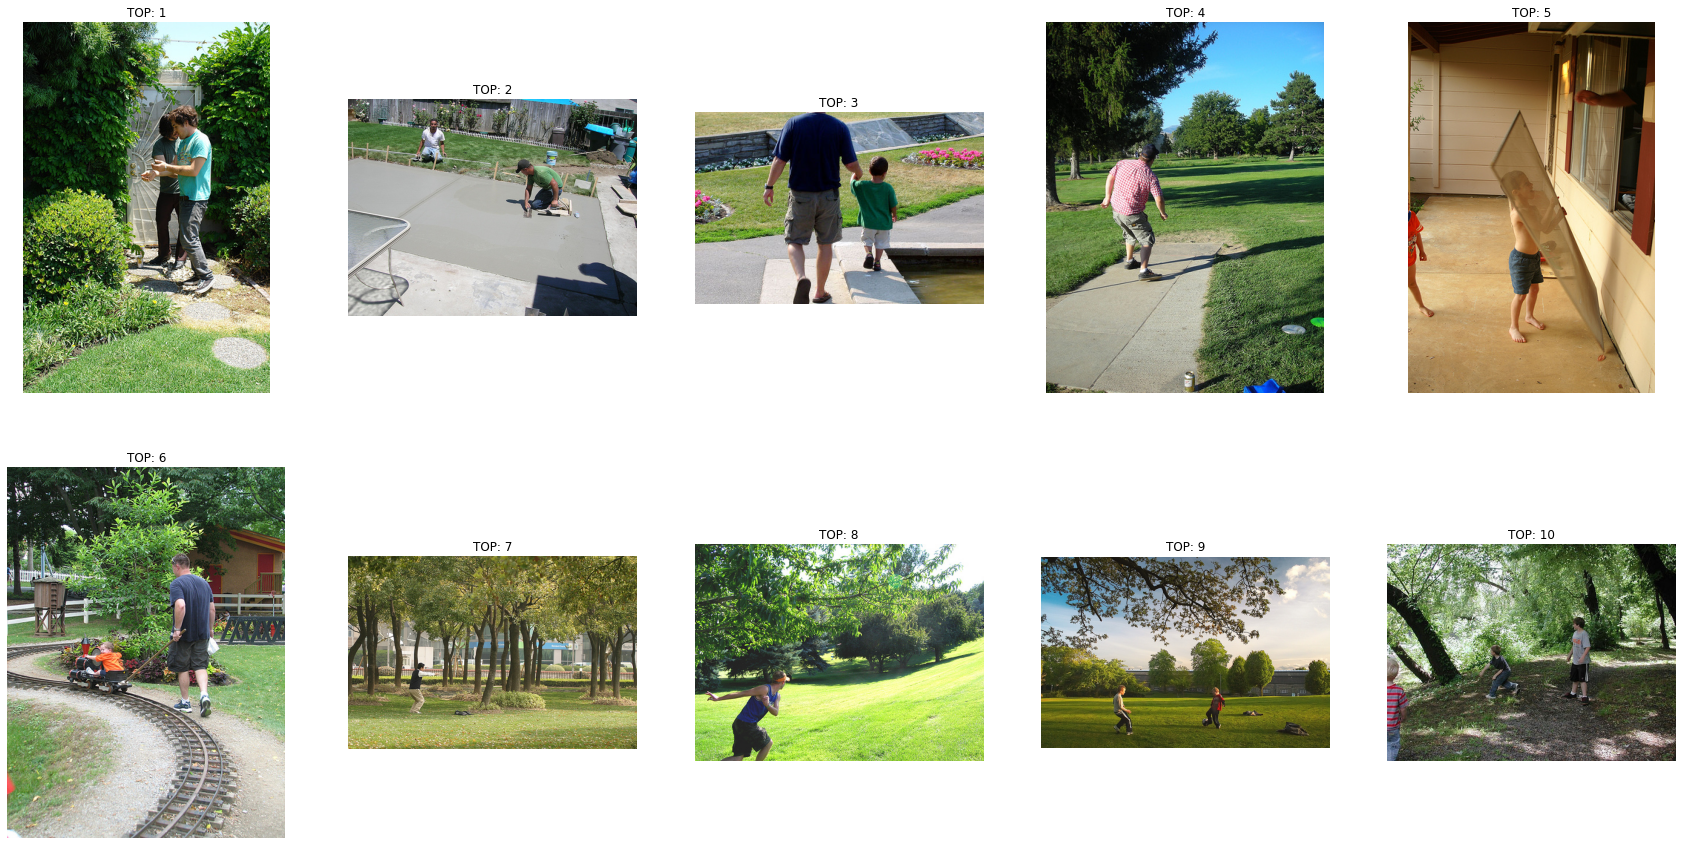

In [18]:
similaridades=np.dot(input_,np.transpose(visual_matrix) )
top=np.argsort(-similaridades)

_, axs = plt.subplots(2, 5, figsize=(30, 15))
axs = axs.flatten()
imgs= [mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + dataset[universe_img[i]]["filename"]) for i in top[:10]]
c=0
for img, ax in zip(imgs, axs):
    c+=1
    ax.imshow(img)
    ax.axis('off')
    ax.set_title( "TOP: "+str(c) )
    
plt.show()

## 3. Búsqueda de imágenes en base a imágenes (utilizando proyección al espacio aprendido)

In [ ]:
indice_input_= 0

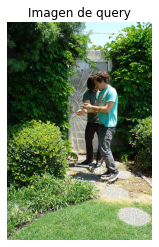

In [29]:
input_=visual_matrix[indice_input_,:]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + dataset[universe_img[indice_input_]]["filename"])
imgplot = plt.imshow(img)
plt.axis('off')
plt.title("Imagen de query")
plt.show()

Aquí los vectores son de 512!

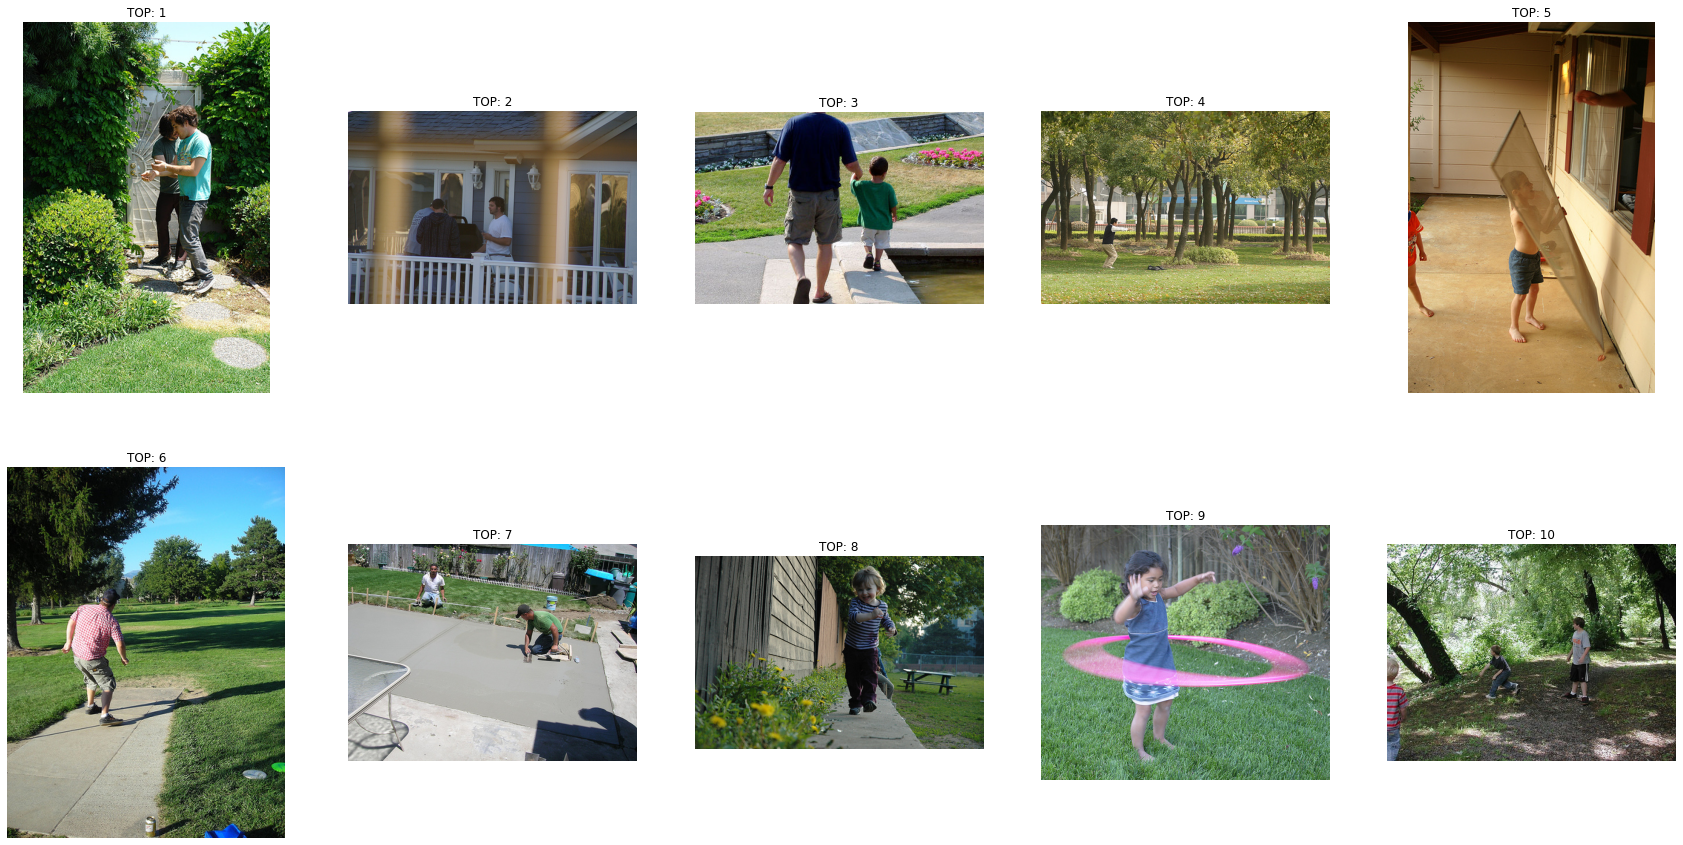

In [28]:
input_proyec=np.dot(input_,np.transpose(param[0]) )
all_proyec=np.dot(visual_matrix,np.transpose(param[0]) )
similaridades=np.dot(input_proyec, np.transpose(all_proyec) )
top=np.argsort(-similaridades)

_, axs = plt.subplots(2, 5, figsize=(30, 15))
axs = axs.flatten()
imgs= [mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + dataset[universe_img[i]]["filename"]) for i in top[:10]]
c=0
for img, ax in zip(imgs, axs):
    c+=1
    ax.imshow(img)
    ax.axis('off')
    ax.set_title( "TOP: "+str(c) )
    
plt.show()

## 4. Búsqueda de imágenes en base a cualquier texto ingresado! 

In [30]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=8e030212c0f70e060f6bd98c54ea9e20ba7067e610f1dbb5d13893e49b1f4b18
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [41]:
input_text="una niña jugando con un ula ula"

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

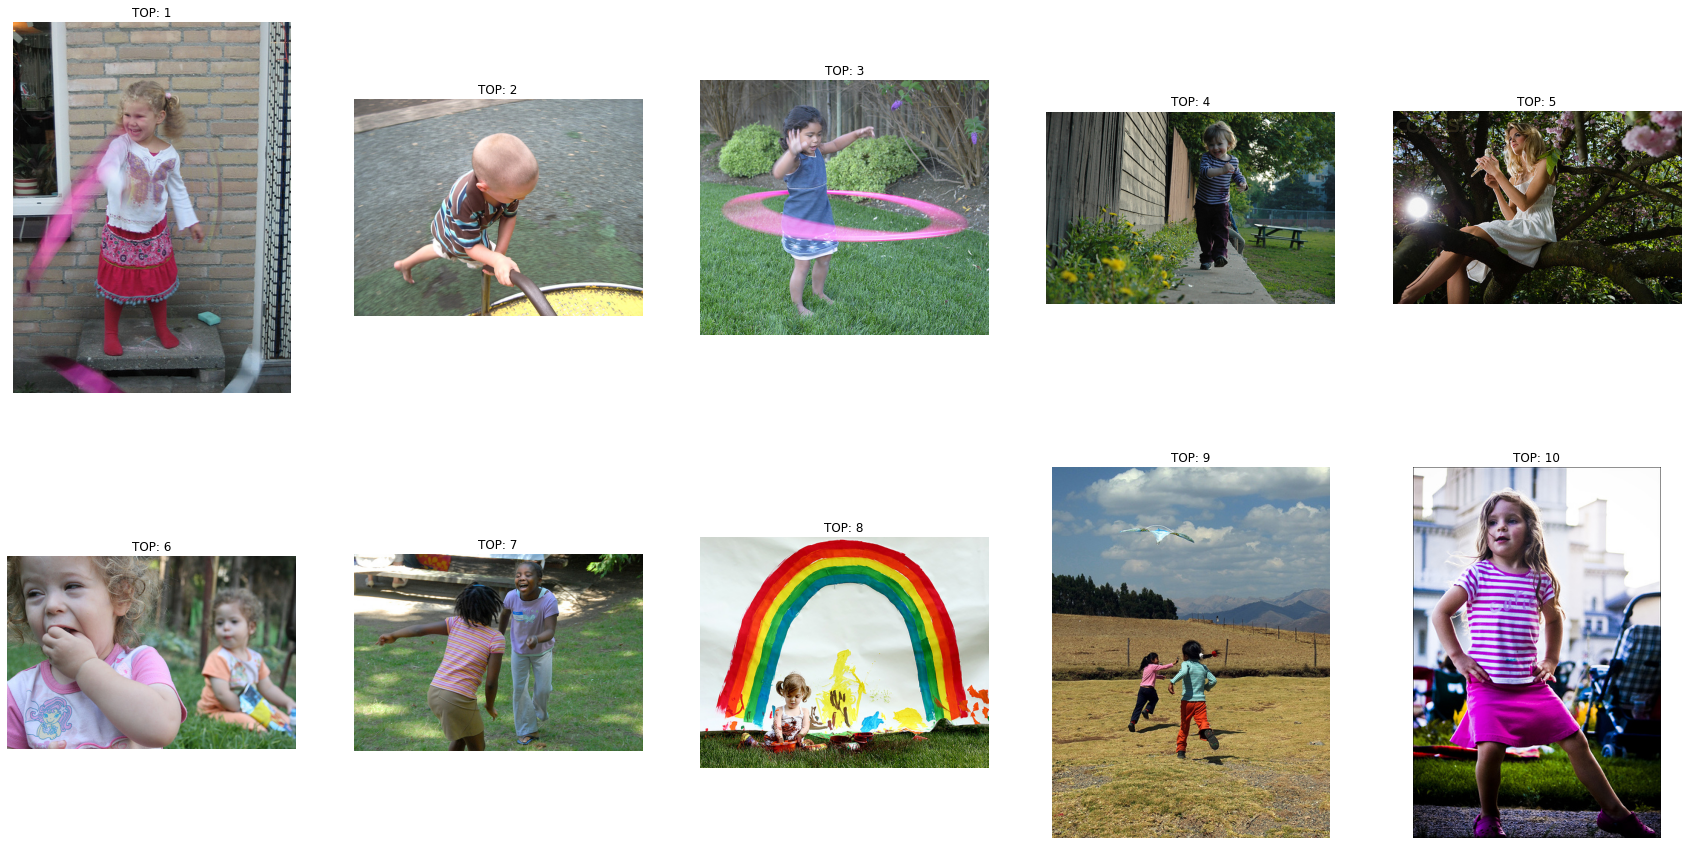

In [42]:
from deep_translator import GoogleTranslator
translated = GoogleTranslator(source='es', target='en').translate(input_text)
embeddings_t= model.encode(translated)

input_proyec=np.dot(embeddings_t,np.transpose(param[1]) )
all_proyec=np.dot(visual_matrix,np.transpose(param[0]) )
similaridades=np.dot(input_proyec, np.transpose(all_proyec) )
top=np.argsort(-similaridades)

_, axs = plt.subplots(2, 5, figsize=(30, 15))
axs = axs.flatten()
imgs= [mpimg.imread("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/" + dataset[universe_img[i]]["filename"]) for i in top[:10]]
c=0
for img, ax in zip(imgs, axs):
    c+=1
    ax.imshow(img)
    ax.axis('off')
    ax.set_title( "TOP: "+str(c) )
    
plt.show()